In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.utils.random_sequence import (powerlaw_sequence)
from tqdm import tqdm
import sys

# import networkx.utils.create_degree_sequence as create_degree_sequence
%matplotlib notebook

## Build a network

In [2]:
def create_degree_sequence(n, sfunction=None, max_tries=50, **kwds):
    """ Attempt to create a valid degree sequence of length n using
    specified function sfunction(n,**kwds).

    Parameters
    ----------
    n : int
        Length of degree sequence = number of nodes
    sfunction: function
        Function which returns a list of n real or integer values.
        Called as "sfunction(n,**kwds)".
    max_tries: int
        Max number of attempts at creating valid degree sequence.

    Notes
    -----

    Repeatedly create a degree sequence by calling sfunction(n,**kwds)
    until achieving a valid degree sequence. If unsuccessful after
    max_tries attempts, raise an exception.
    
    For examples of sfunctions that return sequences of random numbers,
    see networkx.Utils.

    Examples
    --------
    >>> from networkx.utils import uniform_sequence, create_degree_sequence
    >>> seq=create_degree_sequence(10,uniform_sequence)
    """
    tries=0
    max_deg=n
    while tries < max_tries:
        trialseq=sfunction(n,**kwds)
        # round to integer values in the range [0,max_deg]
        seq=[min(max_deg, max( int(round(s)),0 )) for s in trialseq]
        # if graphical return, else throw away and try again
        if nx.is_graphical(seq):
            return seq
        tries+=1
    raise nx.NetworkXError("Exceeded max (%d) attempts at a valid sequence."%max_tries)

exponent = -2.40
graph has 1914 parallel edges
size of largest connected component = 937


<IPython.core.display.Javascript object>


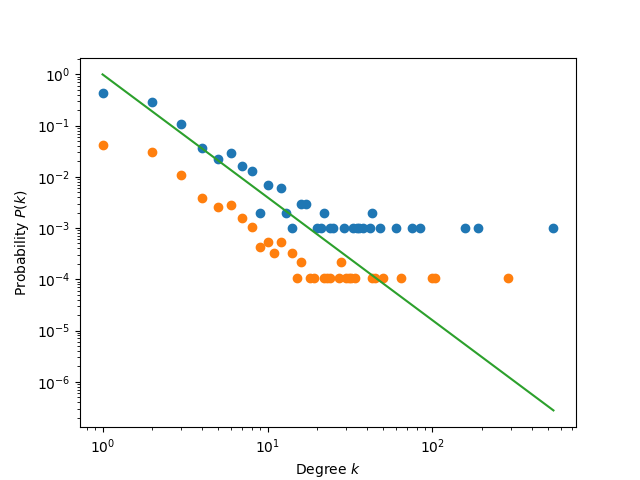

In [3]:
#### code from http://nbviewer.jupyter.org/gist/Midnighter/248f1a5d8c21b39525ae

exp = 2.4
seed = 123456789
num = 1000
print("exponent = -{0:.2f}".format(exp))
sequence = create_degree_sequence(num, powerlaw_sequence, exponent=exp)
graph = nx.configuration_model(sequence, seed=seed)
# count parallel edges and avoid counting A-B as well as B-A
num_par = sum(
    len(graph[node][neigh]) for node in graph
    for neigh in graph.neighbors(node)) // 2
print("graph has {0:d} parallel edges".format(num_par))
loops = graph.selfloop_edges()
# remove them
graph = nx.Graph(graph)
graph.remove_edges_from(loops)
# get largest connected component
# unfortunately, the iterator over the components is not guaranteed to be sorted by size
components = sorted(nx.connected_components(graph), key=len, reverse=True)
lcc = graph.subgraph(components[0])
print("size of largest connected component = {0:d}".format(len(lcc)))
# new degree sequence
simple_seq = [deg for (node, deg) in lcc.degree()]
# create histograms
counts = np.bincount(sequence)
mask = (counts > 0)
plt.figure()
plt.plot(
    np.arange(len(counts))[mask],
    counts[mask] / counts.sum(),
    "o",
    label="MultiGraph")
simple_counts = np.bincount(simple_seq)
mask = (simple_counts > 0)
# distribution is shifted for visibility
plt.plot(
    np.arange(len(simple_counts))[mask],
    simple_counts[mask] / simple_counts.sum() / 10.0,
    "o",
    label="Simple LCC")
x = np.arange(1, len(counts))
plt.plot(x, np.power(x, -exp))
plt.xlabel(r"Degree $k$")
plt.xscale("log")
plt.ylabel(r"Probability $P(k)$")
plt.yscale("log")
plt.title(r"$N = {0:d}, \\quad \\lambda = {1:.2f}$".format(num, exp))
plt.legend(loc="best")
plt.show()

<IPython.core.display.Javascript object>


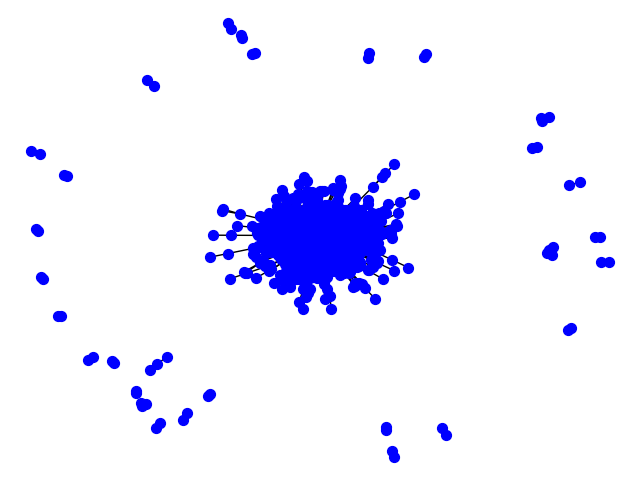

In [4]:
plt.figure()
pos = nx.spring_layout(graph)
nx.draw(graph, pos, node_color='b', node_size=50, with_labels=False)
plt.show()

<IPython.core.display.Javascript object>


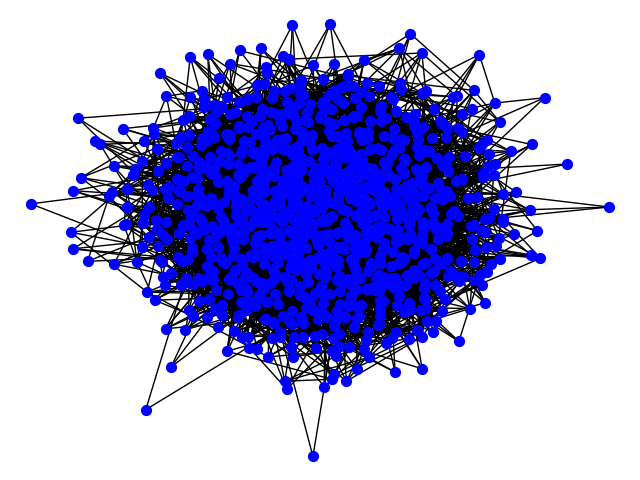

<IPython.core.display.Javascript object>


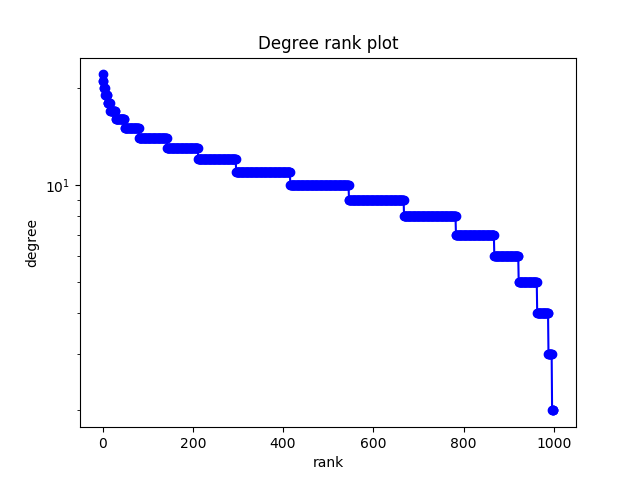

In [5]:
p = 0.01
num = 1000
graph = nx.fast_gnp_random_graph(num, p, seed=seed, directed=False)

plt.figure()
pos = nx.spring_layout(graph)
nx.draw(graph, pos, node_color='b', node_size=50, with_labels=False)
plt.show()

plt.figure()
degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
# print "Degree sequence", degree_sequence
dmax = max(degree_sequence)

plt.semilogy(degree_sequence, 'b-', marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

## Implementation of disease spreading

In [6]:
class Person():
    """ 
    Contains data about status of infection for each person.
    
    time_since_infection equals -1 if person is not infected.
    
    The disease status is 0 for no disease, 1 for the sensitive
    strain and 2 for the resistant strain.
    """
    
    def __init__(self,i):
        self.identifier = i
        self.disease_status = 0
        self.time_since_infection = -1

In [11]:
# set person class to each node
for i in range(len(graph)):
    graph.node[i]["Data"] = Person(i)

# create set of infecteds, initialize with 10 infecteds
infected = set()
init = np.random.choice(len(graph), 10, replace=False)
for i in init:
    graph.node[i]["Data"].disease_status = 1
    infected.add(i)

# graph.node[init[-1]]["Data"].disease_status = 2
# infected.add(init[-1])
    
# define time(steps)
t = 0
t_tot = 10
time_step = 12
dt = 1 / (t_tot * time_step)

# constants of model
phi = 0.64
D = 0.19 * time_step
nu = 1 - (1 - (1 - phi) / D )**(1/time_step)
mu = 1e-3
tau = 1 - (1 - phi / D )**(1/time_step)
beta = 1 - (1 - 0.59)**(1/time_step)
nu = beta*2
print("nu", nu)
print("beta", beta)
print("tau", tau)

# keep track of infecteds and steps
num_steps = int(t_tot/dt)
num_infected  = np.zeros(num_steps)
num_res = np.zeros(num_steps)

# iterate over time
for t in tqdm(range(num_steps), position = 0):
    infected_copy = infected.copy()
    num_infected[t] = num_infected[t-1]
    num_res[t] = num_res[t-1]

    # iterate over infecteds 
    for i in infected_copy:
        
        # prob of recovering
        if np.random.rand() < nu:
            graph.node[i]["Data"].disease_status = 0
            infected.remove(i)

        # prob of treatment
        elif graph.node[i]["Data"].disease_status == 1 and np.random.rand() < tau*(1-mu):
            graph.node[i]["Data"].disease_status = 0
            infected.remove(i)
            
        # prob of getting the resistant strain
        elif graph.node[i]["Data"].disease_status == 1 and np.random.rand() < tau*mu:
            graph.node[i]["Data"].disease_status = 2
        
        # spreading of disease to neigbours
        if graph.node[i]["Data"].disease_status:
            for neighbor in graph.neighbors(i):
                if graph.node[neighbor]["Data"].disease_status == 0 and np.random.rand() < beta:
                    highest_disease = max(
                        graph.node[i]["Data"].disease_status,
                        graph.node[neighbor]["Data"].disease_status)
                    graph.node[i]["Data"].disease_status = highest_disease
                    graph.node[neighbor]["Data"].disease_status = highest_disease
                    infected.add(i)
                    infected.add(neighbor)
    
    # keep track of total number of resistant infecteds
    tot = 0
    for i in infected:
        if graph.node[i]["Data"].disease_status == 2:
            tot += 1
    num_res[t] = tot 
    num_infected[t] = len(infected)
#     sys.stdout.write('\r'+str(t))

  1%|▏         | 17/1200 [00:00<00:07, 164.86it/s]

0.14321344075427556
0.07160672037713778
0.02708309386071206


100%|██████████| 1200/1200 [00:20<00:00, 59.86it/s]


## Plotting

<IPython.core.display.Javascript object>


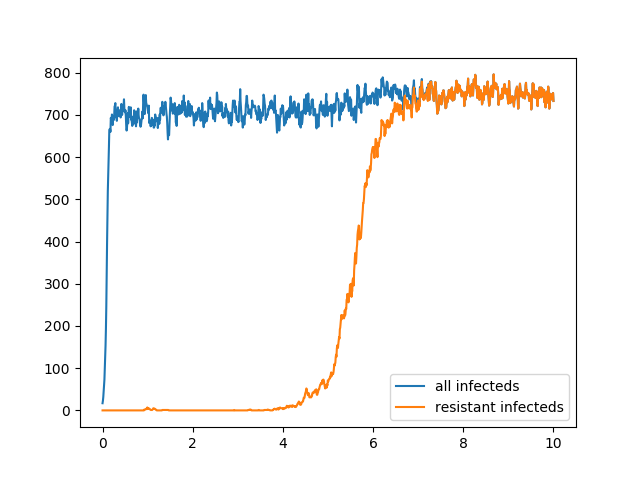

718.615833333


<IPython.core.display.Javascript object>


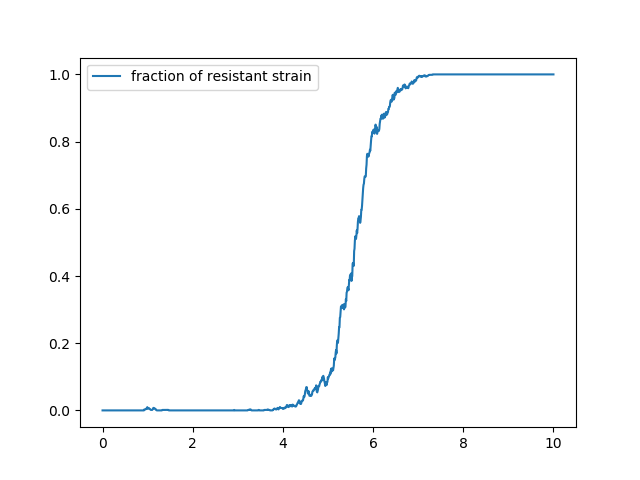

718.615833333


In [15]:
# plot number of infecteds
t = np.linspace(0,t_tot, num_steps)    
plt.figure()
print(np.mean(num_infected))
plt.plot(t, num_infected, label='all infecteds')
plt.plot(t, num_res, label='resistant infecteds')
plt.legend()
plt.show()

plt.figure()
print(np.mean(num_infected))
plt.plot(t,num_res/num_infected, label='fraction of resistant strain')
# plt.plot(num_res)
plt.legend()
plt.show()